In [1]:
import sys
sys.path.append('..')
from src.POMDP import *

In [2]:
import numpy as np
import random

# POMDP Toy Problem

Symmetric 2 state, 2 action model

## Model definition

In [3]:
STAY = 0
MOVE = 1
ACTIONS = [STAY, MOVE]
ACTION_INDEX = {a:a_i for a_i, a in enumerate(ACTIONS)}
ACTION_COUNT = len(ACTIONS)

STATES = [0,1]
STATE_COUNT = len(STATES)

In [4]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup tanle to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, len(ACTIONS), STATE_COUNT))
for s in STATES:
    for a_i, a in enumerate(ACTIONS):
        for s_p in STATES:
            transition_table[s,a_i,s_p] = transition_function(s,a,s_p)

# Randomized transition
def transition(s,a):
    a_i = ACTION_INDEX[a]
    s_p_probs = [transition_table[s, a_i, s_p] for s_p in STATES]
    return np.argmax(np.random.multinomial(n=1, pvals=s_p_probs))

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [5]:
OBS_RND = 0.7 # 70% of observation success
def observation_function(s_p, a, o):
    return OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in STATES:
    for a_i, a in enumerate(ACTIONS):
        for o in STATES:
            observation_table[s_p, a_i, o] = observation_function(s_p, a, o)

# Random observation 
def observe(s):
    return s if random.random() < OBS_RND else random.choice(list(set(STATES) - set([s])))
            
observation_table[:,0,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [6]:
REWARD_PROBS = [0.2, 0.6]
def reward(s):
    return 1 if random.random() < REWARD_PROBS[s] else 0

def reward_function(s, a):
    tot = 0.0
    for s_p in STATES:
        a_i = ACTION_INDEX[a]
        tot += (REWARD_PROBS[s_p] * transition_table[s,a_i,s_p])
    return tot

def immediate_rewards(a):
    return [reward_function(s,a) for s in STATES]

reward_table = np.zeros((STATE_COUNT, len(ACTIONS)))
for s in STATES:
    for a_i,a in enumerate(ACTIONS):
        reward_table[s,a_i] = reward_function(s,a)
        
reward_table

array([[0.28, 0.52],
       [0.52, 0.28]])

In [7]:
for a in ACTIONS:
    for s in STATES:
        print(f'R({s}, {"STAY" if a == STAY else "MOVE"}) = {reward_function(s,a)}')

R(0, STAY) = 0.28
R(1, STAY) = 0.52
R(0, MOVE) = 0.52
R(1, MOVE) = 0.28


In [8]:
states = ['s0','s1']
actions = ['stay', 'move']

model = POMDPModel(states, actions, transition_table, reward_table, observation_table)

## Solving

In [9]:
solver = PBVI(model)

In [10]:
value_function = solver.solve(10,4)

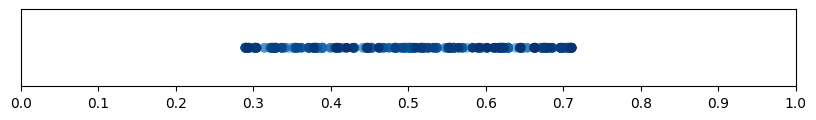

In [11]:
solver.plot_belief_set(10)

In [12]:
value_function

[AlphaVector([4.24515086, 4.48515086]), AlphaVector([4.48515086, 4.24515086])]

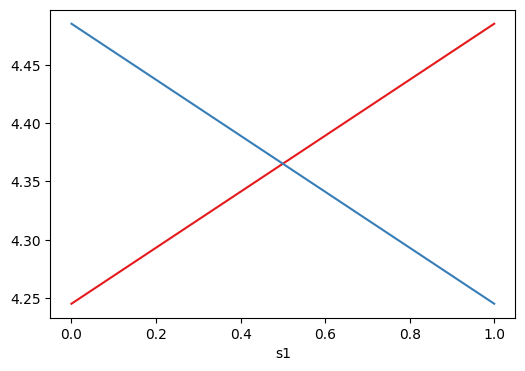

In [13]:
value_function.plot(4)

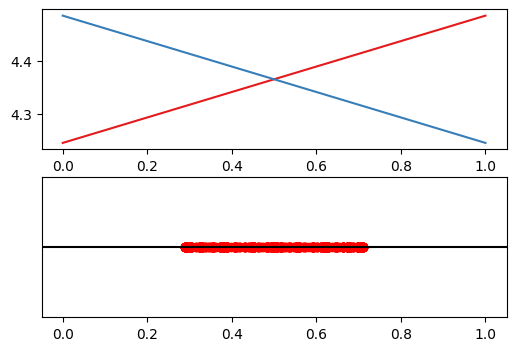

In [14]:
value_function.plot(4, solver.explored_beliefs)